In [45]:
import os
import config
import tensorflow as tf
import tensorflow_datasets as tfds
from losses import YoloLoss
from model import yolov3
from utils.dataset import parse_aug_fn, parse_fn , transform_targets,parse_fn_test
from utils.utils import trainable_model
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Anchors setting
anchor_masks = config.yolo_anchor_masks

In [3]:
def training_model(model, callbacks, num_classes=80, step=1):
    if step == 1:
        batch_size = config.step1_batch_size
        learning_rate = config.step1_learning_rate
        start_epochs = config.step1_start_epochs
        end_epochs = config.step1_end_epochs

    else:
        batch_size = config.step2_batch_size
        learning_rate = config.step2_learning_rate
        start_epochs = config.step2_start_epochs
        end_epochs = config.step2_end_epochs
    anchors = config.yolo_anchors / 416

    # Training dataset setting
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    combined_split = "train+validation"
    train_data = tfds.load("voc", split=combined_split)
    train_data = train_data.shuffle(1000)
    train_data = train_data.map(lambda dataset: parse_aug_fn(dataset), num_parallel_calls=AUTOTUNE)
    train_data = train_data.batch(batch_size)
    train_data = train_data.map(lambda x, y: transform_targets(x, y, anchors, anchor_masks),
                                num_parallel_calls=AUTOTUNE)
    train_data = train_data.prefetch(buffer_size=AUTOTUNE)

    # Validation dataset setting
    val_data = tfds.load("voc", split=tfds.Split.TEST)
    val_data = val_data.map(lambda dataset: parse_fn(dataset), num_parallel_calls=AUTOTUNE)
    val_data = val_data.batch(batch_size)
    val_data = val_data.map(lambda x, y: transform_targets(x, y, anchors, anchor_masks), num_parallel_calls=AUTOTUNE)
    val_data = val_data.prefetch(buffer_size=AUTOTUNE)

    # Training
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=[YoloLoss(anchors[mask], num_classes=num_classes) for mask in anchor_masks],
                  run_eagerly=False)
    model.fit(train_data,
              epochs=end_epochs,
              callbacks=callbacks,
              validation_data=val_data,
              initial_epoch=start_epochs)


In [4]:
def run():
    # Dataset Info
    num_classes = len(config.voc_classes)

    # Create model
    model = yolov3((config.size_h, config.size_w, 3), num_classes=num_classes, training=True)
    model.summary()

    # Load Weights
    model.load_weights(config.yolo_weights, by_name=True)

    # Callbacks function
    log_dir = r'C:\yolo\yolov3 MMSLAB-DL\MMSLAB-DL-master\Lab12\logs_yolo'
    model_dir = log_dir + '\\models'
    os.makedirs(model_dir, exist_ok=True)
    model_tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    model_mckp = tf.keras.callbacks.ModelCheckpoint(model_dir + '\\best_{epoch:03d}.h5',
                                                    monitor='val_loss',  # TODO: mAP
                                                    save_best_only=True,
                                                    mode='min')
    model_ep = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    mdoel_rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1)

    # Freeze all layers in except last layer
    trainable_model(model, trainable=False)
    model.get_layer('conv2d_last_layer1_20').trainable = True
    model.get_layer('conv2d_last_layer2_20').trainable = True
    model.get_layer('conv2d_last_layer3_20').trainable = True

    # 1) Training model step1
    print("Start teraining Step1")
    training_model(model,
                   callbacks=[model_tb,  mdoel_rlr, model_ep],
                   num_classes=num_classes,
                   step=1)

    # Unfreeze layers
    trainable_model(model, trainable=True)

    # 2) Training model step2
    print("Start teraining Step2")
    training_model(model,
                   callbacks=[model_tb, mdoel_rlr, model_ep],
                   num_classes=num_classes,
                   step=2)
    return model

In [5]:
model = run()

Model: "Yolo-V3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
Yolo_DarkNet (Functional)       ((None, None, None,  40620640    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 13, 13, 512)  524288      Yolo_DarkNet[0][2]               
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 13, 13, 512)  2048        conv2d_52[0][0]                  
____________________________________________________________________________________________

Start teraining Step1


Epoch 1/100
  1/314 [..............................] - ETA: 0s - loss: 9640.4092 - yolo_output_box_layer_loss: 349.5910 - yolo_output_box_layer_1_loss: 920.9659 - yolo_output_box_layer_2_loss: 8360.0137WARNING:tensorflow:From C:\Users\server\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


314/314 [==============================] - 302s 961ms/step - loss: 431.7520 - yolo_output_box_layer_loss: 14.1771 - yolo_output_box_layer_1_loss: 31.4741 - yolo_output_box_layer_2_loss: 376.2483 - val_loss: 54.1937 - val_yolo_output_box_layer_loss: 6.0344 - val_yolo_output_box_layer_1_loss: 10.0458 - val_yolo_output_box_layer_2_loss: 28.2502
Epoch 2/100
314/314 [==============================] - 299s 953ms/step - loss: 41.8742 - yolo_output_box_layer_loss: 4.9974 - yolo_output_box_layer_1_loss: 8.6862 - yolo_output_box_layer_2_loss: 18.3264 - val_loss: 33.9334 - val_yolo_output_box_layer_loss: 4.3932 - val_yolo_output_box_layer_1_loss: 7.5118 - val_yolo_output_box_layer_2_loss: 12.1643
Epoch 3/100
314/314 [==============================] - 299s 953ms/step - loss: 30.2965 - yolo_output_box_layer_loss: 3.8598 - yolo_output_box_layer_1_loss: 6.7407 - yolo_output_box_layer_2_loss: 9.8328 - val_loss: 27.4097 - val_yolo_output_box_layer_loss: 3.6260 - val_yolo_output_box_layer_1_loss: 6.0755

314/314 [==============================] - 300s 955ms/step - loss: 17.4552 - yolo_output_box_layer_loss: 2.1614 - yolo_output_box_layer_1_loss: 3.3206 - yolo_output_box_layer_2_loss: 2.1243 - val_loss: 17.5204 - val_yolo_output_box_layer_loss: 2.3719 - val_yolo_output_box_layer_1_loss: 3.1863 - val_yolo_output_box_layer_2_loss: 2.1127
Epoch 25/100
314/314 [==============================] - 299s 953ms/step - loss: 17.2684 - yolo_output_box_layer_loss: 2.1458 - yolo_output_box_layer_1_loss: 3.2123 - yolo_output_box_layer_2_loss: 2.0608 - val_loss: 17.6013 - val_yolo_output_box_layer_loss: 2.4664 - val_yolo_output_box_layer_1_loss: 3.1992 - val_yolo_output_box_layer_2_loss: 2.0861
Epoch 26/100
314/314 [==============================] - 299s 954ms/step - loss: 17.2995 - yolo_output_box_layer_loss: 2.0846 - yolo_output_box_layer_1_loss: 3.2353 - yolo_output_box_layer_2_loss: 2.1290 - val_loss: 17.3797 - val_yolo_output_box_layer_loss: 2.2705 - val_yolo_output_box_layer_1_loss: 3.2312 - val_

314/314 [==============================] - ETA: 0s - loss: 16.9228 - yolo_output_box_layer_loss: 2.1074 - yolo_output_box_layer_1_loss: 3.2111 - yolo_output_box_layer_2_loss: 1.7393
Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
314/314 [==============================] - 299s 953ms/step - loss: 16.9228 - yolo_output_box_layer_loss: 2.1074 - yolo_output_box_layer_1_loss: 3.2111 - yolo_output_box_layer_2_loss: 1.7393 - val_loss: 17.0292 - val_yolo_output_box_layer_loss: 2.2542 - val_yolo_output_box_layer_1_loss: 3.2257 - val_yolo_output_box_layer_2_loss: 1.6844
Epoch 48/100
314/314 [==============================] - 300s 954ms/step - loss: 16.1795 - yolo_output_box_layer_loss: 1.7604 - yolo_output_box_layer_1_loss: 2.9326 - yolo_output_box_layer_2_loss: 1.6224 - val_loss: 16.4582 - val_yolo_output_box_layer_loss: 1.9871 - val_yolo_output_box_layer_1_loss: 2.9949 - val_yolo_output_box_layer_2_loss: 1.6126
Epoch 49/100
314/314 [============================

Epoch 70/100
314/314 [==============================] - 299s 954ms/step - loss: 15.8352 - yolo_output_box_layer_loss: 1.5996 - yolo_output_box_layer_1_loss: 2.8537 - yolo_output_box_layer_2_loss: 1.5394 - val_loss: 16.2899 - val_yolo_output_box_layer_loss: 1.9065 - val_yolo_output_box_layer_1_loss: 2.9597 - val_yolo_output_box_layer_2_loss: 1.5815
Epoch 71/100
314/314 [==============================] - 299s 953ms/step - loss: 15.9207 - yolo_output_box_layer_loss: 1.6455 - yolo_output_box_layer_1_loss: 2.8309 - yolo_output_box_layer_2_loss: 1.6023 - val_loss: 16.3183 - val_yolo_output_box_layer_loss: 1.9378 - val_yolo_output_box_layer_1_loss: 2.9548 - val_yolo_output_box_layer_2_loss: 1.5839
Epoch 72/100
314/314 [==============================] - 300s 954ms/step - loss: 15.9808 - yolo_output_box_layer_loss: 1.6172 - yolo_output_box_layer_1_loss: 2.8855 - yolo_output_box_layer_2_loss: 1.6366 - val_loss: 16.2864 - val_yolo_output_box_layer_loss: 1.9103 - val_yolo_output_box_layer_1_loss: 

Epoch 93/100
314/314 [==============================] - 299s 952ms/step - loss: 15.9290 - yolo_output_box_layer_loss: 1.6356 - yolo_output_box_layer_1_loss: 2.8671 - yolo_output_box_layer_2_loss: 1.5888 - val_loss: 16.2454 - val_yolo_output_box_layer_loss: 1.8946 - val_yolo_output_box_layer_1_loss: 2.9395 - val_yolo_output_box_layer_2_loss: 1.5737
Epoch 94/100
314/314 [==============================] - 299s 953ms/step - loss: 15.8960 - yolo_output_box_layer_loss: 1.6430 - yolo_output_box_layer_1_loss: 2.8731 - yolo_output_box_layer_2_loss: 1.5424 - val_loss: 16.2419 - val_yolo_output_box_layer_loss: 1.8932 - val_yolo_output_box_layer_1_loss: 2.9379 - val_yolo_output_box_layer_2_loss: 1.5733
Epoch 95/100
314/314 [==============================] - 300s 955ms/step - loss: 15.8835 - yolo_output_box_layer_loss: 1.6129 - yolo_output_box_layer_1_loss: 2.8603 - yolo_output_box_layer_2_loss: 1.5729 - val_loss: 16.2382 - val_yolo_output_box_layer_loss: 1.8905 - val_yolo_output_box_layer_1_loss: 

Epoch 101/200
   2/2506 [..............................] - ETA: 17:20 - loss: 12.1388 - yolo_output_box_layer_loss: 0.3546 - yolo_output_box_layer_1_loss: 0.8363 - yolo_output_box_layer_2_loss: 1.1111WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1312s vs `on_train_batch_end` time: 0.6995s). Check your callbacks.


2506/2506 [==============================] - 1150s 459ms/step - loss: 23.1586 - yolo_output_box_layer_loss: 5.6790 - yolo_output_box_layer_1_loss: 5.1770 - yolo_output_box_layer_2_loss: 2.3227 - val_loss: 21.3876 - val_yolo_output_box_layer_loss: 5.0122 - val_yolo_output_box_layer_1_loss: 4.2221 - val_yolo_output_box_layer_2_loss: 2.0746
Epoch 102/200
2506/2506 [==============================] - 1147s 458ms/step - loss: 22.0006 - yolo_output_box_layer_loss: 5.0591 - yolo_output_box_layer_1_loss: 4.7834 - yolo_output_box_layer_2_loss: 1.9983 - val_loss: 21.3476 - val_yolo_output_box_layer_loss: 4.8883 - val_yolo_output_box_layer_1_loss: 4.2067 - val_yolo_output_box_layer_2_loss: 2.0321
Epoch 103/200
2506/2506 [==============================] - 1146s 457ms/step - loss: 22.2455 - yolo_output_box_layer_loss: 5.2303 - yolo_output_box_layer_1_loss: 4.6920 - yolo_output_box_layer_2_loss: 1.9669 - val_loss: 21.8812 - val_yolo_output_box_layer_loss: 4.9845 - val_yolo_output_box_layer_1_loss: 4.

2506/2506 [==============================] - 1148s 458ms/step - loss: 12.9674 - yolo_output_box_layer_loss: 1.1573 - yolo_output_box_layer_1_loss: 1.4549 - yolo_output_box_layer_2_loss: 0.8124 - val_loss: 20.5004 - val_yolo_output_box_layer_loss: 4.1034 - val_yolo_output_box_layer_1_loss: 4.5834 - val_yolo_output_box_layer_2_loss: 2.2984
Epoch 124/200
2506/2506 [==============================] - 1148s 458ms/step - loss: 12.9203 - yolo_output_box_layer_loss: 1.1495 - yolo_output_box_layer_1_loss: 1.4591 - yolo_output_box_layer_2_loss: 0.8229 - val_loss: 20.3404 - val_yolo_output_box_layer_loss: 4.0548 - val_yolo_output_box_layer_1_loss: 4.5350 - val_yolo_output_box_layer_2_loss: 2.2882
Epoch 125/200
2506/2506 [==============================] - 1150s 459ms/step - loss: 12.6453 - yolo_output_box_layer_loss: 1.1265 - yolo_output_box_layer_1_loss: 1.3304 - yolo_output_box_layer_2_loss: 0.7523 - val_loss: 20.2836 - val_yolo_output_box_layer_loss: 4.1087 - val_yolo_output_box_layer_1_loss: 4.

2506/2506 [==============================] - 1147s 458ms/step - loss: 10.9099 - yolo_output_box_layer_loss: 0.7410 - yolo_output_box_layer_1_loss: 1.0018 - yolo_output_box_layer_2_loss: 0.6227 - val_loss: 20.3848 - val_yolo_output_box_layer_loss: 4.4786 - val_yolo_output_box_layer_1_loss: 4.9204 - val_yolo_output_box_layer_2_loss: 2.4594
Epoch 147/200
2506/2506 [==============================] - 1147s 458ms/step - loss: 10.9597 - yolo_output_box_layer_loss: 0.7894 - yolo_output_box_layer_1_loss: 1.0382 - yolo_output_box_layer_2_loss: 0.6235 - val_loss: 20.5253 - val_yolo_output_box_layer_loss: 4.6010 - val_yolo_output_box_layer_1_loss: 4.9167 - val_yolo_output_box_layer_2_loss: 2.5169
Epoch 148/200
2506/2506 [==============================] - 1147s 458ms/step - loss: 10.9401 - yolo_output_box_layer_loss: 0.7895 - yolo_output_box_layer_1_loss: 1.0587 - yolo_output_box_layer_2_loss: 0.6189 - val_loss: 20.5327 - val_yolo_output_box_layer_loss: 4.5038 - val_yolo_output_box_layer_1_loss: 5.

In [42]:
def test_and_show_result(model, test_number=10):
    for img_count, data in enumerate(test_data.take(test_number)):
        org_img = data['image'].numpy()
        h, w, _ = data['image'].shape
        img, bboxes = parse_fn_test(data)
        #  Predict
        boxes, scores, classes, nums = model.predict(tf.expand_dims(img, axis=0))
        boxes, scores, classes, nums = boxes[0], scores[0], classes[0], int(nums[0])
        # Draw predict bounding box
        print(nums)
        for i in range(nums):
            x1y1 = tuple((np.array(boxes[i][0:2]) * (w, h)).astype(np.int32))
            x2y2 = tuple((np.array(boxes[i][2:4]) * (w, h)).astype(np.int32))
            cv2.rectangle(org_img, x1y1, x2y2, colors[int(classes[i])], 2)
            cv2.putText(org_img,
                        '{} {:.4f}'.format(classes_list[int(classes[i])], scores[i]),
                        x1y1,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, colors[int(classes[i])], 2)
        plt.figure()
        plt.imshow(org_img)
#         plt.imsave('output_images/output_{}.png'.format(img_count), org_img)
    plt.show()

In [53]:
colors = (plt.cm.hsv(np.linspace(0, 1, 80)) * 255).astype(np.int).tolist()
classes_list = config.voc_classes
num_classes = len(config.voc_classes)
model2 = yolov3((config.size_h, config.size_w, 3), num_classes=num_classes, training=False)
model2.set_weights(model.get_weights()) 

1
5
0
0
2
2
1
0
2
3


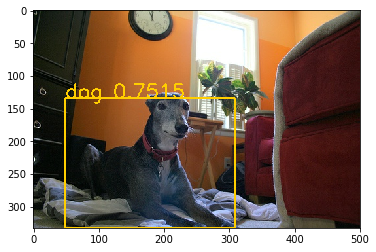

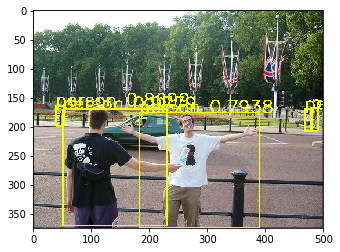

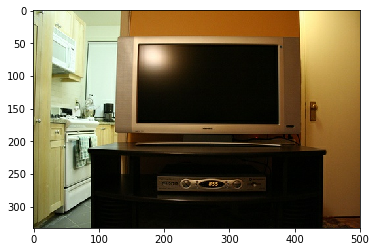

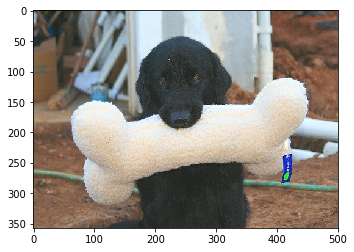

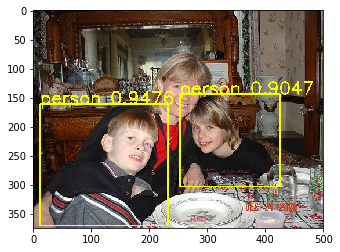

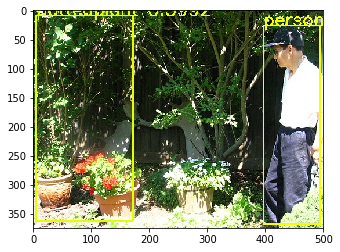

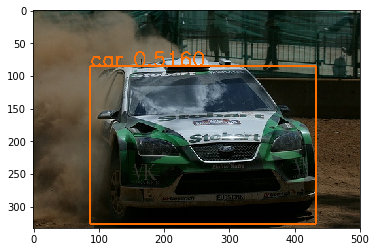

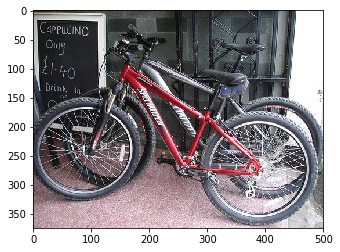

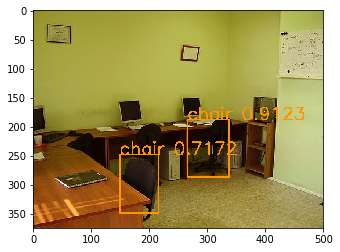

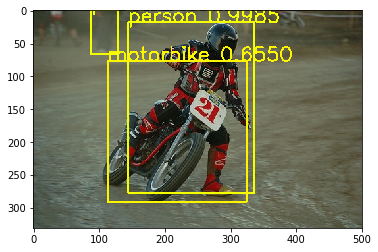

In [50]:
test_data = tfds.load("voc", split=tfds.Split.TEST)
test_and_show_result(model2, test_number=10)